# 10. CHICAGO AIRBNB: MODEL TUNING

## 1. Recap

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
pd.set_option("display.max_columns", 99)
pd.set_option("display.max_rows", 999)
pd.set_option('precision', 3)

chicago = pd.read_csv('data/chicago_airbnb3')

num_cols = ['host_rr', 'host_ar', 'latitude', 'longitude', 'accommodates',
            'baths', 'bedrooms', 'beds', 'min_nights', 'max_nights', 'n_reviews', 
            'rs_rating', 'rs_accuracy', 'rs_cleanliness', 'rs_check_in', 
            'rs_communication', 'rs_location', 'rs_value', 'reviews_per_month']

cat_cols = ['host_rt', 'neighborhood', 'property_type', 'room_type']

train, test = train_test_split(chicago, test_size=0.2, random_state=42)

X_train = train.drop('price', axis=1)
y_train = train['price']

X_test = test.drop('price', axis=1)
y_test = test['price']

X_train.shape, y_train.shape, X_test.shape, y_test.shape

((5240, 25), (5240,), (1310, 25), (1310,))

In [2]:
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer

class AttributeAdder(BaseEstimator, TransformerMixin):    
    def __init__(self):
        self    
        
    def fit(self, df, y = None):               
        return self

    def transform(self, df):        
        df_ = df.copy()
        df_['beds_per_bdrm'] = df_['beds']/df_['bedrooms']
        df_['baths_per_bed'] = df_['baths']/df_['beds']
        df_.replace(np.inf, 0, inplace=True)
        df_.replace(np.nan, 0, inplace=True)
        return df_
    
num_pipe = Pipeline(steps = [
    ('add_features', AttributeAdder()),
    ('std_scaling', StandardScaler())
])
full_pipe = ColumnTransformer(
    transformers=[
        ('num_prep', num_pipe, num_cols),
        ('cat_prep', OneHotEncoder(sparse=False), cat_cols)
    ])

X_train = full_pipe.fit_transform(X_train)
X_test = full_pipe.transform(X_test)

X_train.shape, X_test.shape

((5240, 93), (1310, 93))

In [3]:
model_df = pd.read_csv('data/chicago_airbnb4_models')
model_df.columns = ['RMSE', 'OLS_LR_all', 'OLS_LR_36', 'ElasNet_36', 
                    'KNN_all', 'RandFor_all']
model_df

,RMSE,OLS_LR_all,OLS_LR_36,ElasNet_36,KNN_all,RandFor_all
0,rmse_1,425.931,552.859,552.819,417.219,422.306
1,rmse_2,183.527,210.802,210.359,185.514,184.979
2,rmse_3,134.728,123.628,118.106,123.416,134.961
3,rmse_4,138.456,128.244,123.103,135.151,136.021
4,rmse_5,413.153,590.703,590.501,419.743,421.211
5,rmse_6,447.291,463.421,461.630,450.736,449.103
6,rmse_7,568.169,143.516,138.461,566.424,572.348
7,rmse_8,140.921,123.251,119.284,134.056,150.106
8,rmse_9,444.477,129.995,123.141,442.413,447.136
9,rmse_10,130.011,412.477,412.350,113.691,114.374


## 2. Reducing Features Using Principal Components
We want to reduce the number of features while retaining the variance in the data

In [4]:
from sklearn.decomposition import PCA

pca = PCA(n_components=0.95, whiten=True)
X_train_pca = pca.fit_transform(X_train)

print("Original number of features:", X_train.shape[1])
print("Reduced number of features:", X_train_pca.shape[1])

Original number of features: 93
Reduced number of features: 26


The output of our solution shows that PCA let us reduce our dimensionality by a wopping 67 (72%) features while still retaining 95% of the information (variance) in the feature matrix.

In [5]:
pca.explained_variance_

array([4.64938613, 3.48702325, 2.07064037, 1.51684252, 1.34904604,
       1.15115221, 1.09107001, 0.91861542, 0.84215224, 0.75376112,
       0.71785418, 0.56043914, 0.43234613, 0.38420376, 0.3724925 ,
       0.31875881, 0.3071287 , 0.28155298, 0.26640015, 0.22223678,
       0.1734344 , 0.16193853, 0.14135618, 0.13142378, 0.12928797,
       0.09760897])

## 3. Plotting PCA's Explained Variance

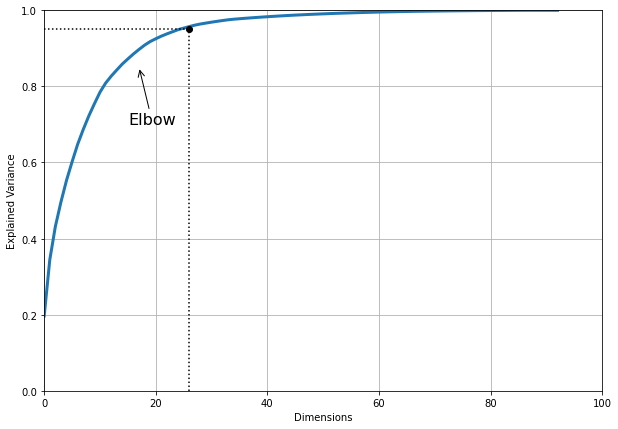

In [6]:
import matplotlib.pyplot as plt

pca_1 = PCA()
pca_1.fit(X_train)
cumsum = np.cumsum(pca_1.explained_variance_ratio_)
d = np.argmax(cumsum >= 0.95) + 1

plt.figure(figsize=(10,7))
plt.plot(cumsum, linewidth=3)
plt.axis([0, 100, 0, 1])
plt.xlabel("Dimensions")
plt.ylabel("Explained Variance")
plt.plot([d, d], [0, 0.95], "k:")
plt.plot([0, d], [0.95, 0.95], "k:")
plt.plot(d, 0.95, "ko")
plt.annotate("Elbow", xy=(17, 0.85), xytext=(15, 0.7),
             arrowprops=dict(arrowstyle="->"), fontsize=16)
plt.grid(True)
plt.show()

## 4. Training KNN with PCA

In [8]:
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import GridSearchCV

knn_model = Pipeline([
    ('pca', PCA(n_components=0.95, whiten=True)),
    ('knn', KNeighborsRegressor())
])
kpar = {'knn__n_neighbors': np.arange(1, 21, 2),
       'knn__weights': ['uniform', 'distance'],
       'knn__algorithm': ['ball_tree', 'kd_tree', 'brute'],
       'knn__p': [1,2]
      }
kgrid = GridSearchCV(knn_model, kpar, n_jobs=-1, cv=10)
kgrid.fit(X_train, y_train)     

print('Best Parameters:', kgrid.best_params_)
print('Best Score:', kgrid.best_score_)

Best Parameters: {'knn__algorithm': 'ball_tree', 'knn__n_neighbors': 19, 'knn__p': 1, 'knn__weights': 'uniform'}
Best Score: 0.1285674892499459


In [10]:
from sklearn.model_selection import cross_val_score

knn_model = Pipeline([
    ('pca', PCA(n_components=0.95, whiten=True)),
    ('knn', KNeighborsRegressor(algorithm='ball_tree', 
                                n_neighbors=19,
                                p=1, 
                                weights='uniform'))
])
knn_mse = cross_val_score(knn_model, X_train, y_train, cv=10, n_jobs=-1, 
                             scoring="neg_mean_squared_error") 
knn_rmse = np.sqrt(np.absolute(knn_mse))
print('RMSE:', knn_rmse)
print('Avg_RMSE:', knn_rmse.mean())
print('Std_RMSE:', knn_rmse.std())

RMSE: [438.55526927 188.60044533 127.74280555 146.01301654 420.36460747
 446.4599752  568.93278988 143.56518896 444.51846024 124.2923112 ]
Avg_RMSE: 304.904486963505
Std_RMSE: 164.08688293576697


In [11]:
model_df['KNN_pca0.95'] = [438.55526927, 188.60044533, 127.74280555, 146.01301654,
                           420.36460747, 446.4599752,  568.93278988, 143.56518896,
                           444.51846024, 124.2923112, 304.904486963505, 164.08688293576697]
model_df

,RMSE,OLS_LR_all,OLS_LR_36,ElasNet_36,KNN_all,RandFor_all,KNN_pca0.95
0,rmse_1,425.931,552.859,552.819,417.219,422.306,438.555
1,rmse_2,183.527,210.802,210.359,185.514,184.979,188.600
2,rmse_3,134.728,123.628,118.106,123.416,134.961,127.743
3,rmse_4,138.456,128.244,123.103,135.151,136.021,146.013
4,rmse_5,413.153,590.703,590.501,419.743,421.211,420.365
5,rmse_6,447.291,463.421,461.630,450.736,449.103,446.460
6,rmse_7,568.169,143.516,138.461,566.424,572.348,568.933
7,rmse_8,140.921,123.251,119.284,134.056,150.106,143.565
8,rmse_9,444.477,129.995,123.141,442.413,447.136,444.518
9,rmse_10,130.011,412.477,412.350,113.691,114.374,124.292


So PCA did not improve the KNN model. Let's try Random Forest

## 5. Training Random Forest with PCA

In [12]:
from sklearn.ensemble import RandomForestRegressor

ran_pca = Pipeline([
    ('pca', PCA(n_components=0.95, whiten=True)),
    ('ran', RandomForestRegressor())
])
ranpar = {'ran__max_depth': [2, 4, 6, 8],
          'ran__min_samples_leaf': [1, 2, 3, 4],
          'ran__min_samples_split':[2, 3, 4, 5]
         }
rangrid = GridSearchCV(ran_pca, ranpar, n_jobs=-1, cv=10)
rangrid.fit(X_train, y_train)

print('Best Parameters:', rangrid.best_params_)
print('Best Score:', rangrid.best_score_)

Best Parameters: {'ran__max_depth': 2, 'ran__min_samples_leaf': 1, 'ran__min_samples_split': 2}
Best Score: 0.06370930279716588


In [14]:
ran_pca = Pipeline([
    ('pca', PCA(n_components=0.95, whiten=True)),
    ('ran', RandomForestRegressor(max_depth=2, min_samples_leaf=1,
                            min_samples_split=2))
])
ranfo_mse = cross_val_score(ran_pca, X_train, y_train, cv=10, n_jobs=-1, 
                             scoring="neg_mean_squared_error") 
ranfo_rmse = np.sqrt(np.absolute(ranfo_mse))
print('RMSE:', ranfo_rmse)
print('Avg_RMSE:', ranfo_rmse.mean())
print('Std_RMSE:', ranfo_rmse.std())

RMSE: [439.47246945 211.00742227 141.79015851 146.55941033 427.4270381
 423.95582045 572.69314711 153.61692199 445.07800563 151.15726628]
Avg_RMSE: 311.27576601234045
Std_RMSE: 156.61073676562975


In [15]:
model_df['RanFor_pca0.95'] = [439.47246945, 211.00742227, 141.79015851, 146.55941033,
                              427.4270381, 423.95582045, 572.69314711, 153.61692199,
                              445.07800563, 151.15726628, 311.27576601234045, 156.61073676562975]
model_df

,RMSE,OLS_LR_all,OLS_LR_36,ElasNet_36,KNN_all,RandFor_all,KNN_pca0.95,RanFor_pca0.95
0,rmse_1,425.931,552.859,552.819,417.219,422.306,438.555,439.472
1,rmse_2,183.527,210.802,210.359,185.514,184.979,188.600,211.007
2,rmse_3,134.728,123.628,118.106,123.416,134.961,127.743,141.790
3,rmse_4,138.456,128.244,123.103,135.151,136.021,146.013,146.559
4,rmse_5,413.153,590.703,590.501,419.743,421.211,420.365,427.427
5,rmse_6,447.291,463.421,461.630,450.736,449.103,446.460,423.956
6,rmse_7,568.169,143.516,138.461,566.424,572.348,568.933,572.693
7,rmse_8,140.921,123.251,119.284,134.056,150.106,143.565,153.617
8,rmse_9,444.477,129.995,123.141,442.413,447.136,444.518,445.078
9,rmse_10,130.011,412.477,412.350,113.691,114.374,124.292,151.157


So PCA is definitely making things worse. 
## 6. Linear Regression with Recursive Feature Elimination

In [24]:
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import RFECV

ols = LinearRegression()
rfecv = RFECV(estimator=ols, step=1, cv=10,
              scoring="neg_mean_squared_error")
rfecv.fit(X_train, y_train)
X_train_rfe = rfecv.transform(X_train)
rfecv.n_features_

81

In [18]:
rfecv.ranking_

array([ 1, 13,  1,  1,  1,  1,  3,  1,  6, 12,  9,  5,  7,  2,  8, 10, 11,
        4,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1])

In [25]:
ols = LinearRegression()
ols_mse = cross_val_score(ols, X_train_rfe, y_train, cv=10, n_jobs=-1, 
                             scoring="neg_mean_squared_error") 
ols_rmse = np.sqrt(np.absolute(ols_mse))
print('RMSE:', ols_rmse)
print('Avg_RMSE:', ols_rmse.mean())
print('Std_RMSE:', ols_rmse.std())

RMSE: [425.88957391 182.8997185  130.36298916 137.69506409 411.7671563
 446.81798781 565.0406336  139.44482437 444.54116197 113.28733245]
Avg_RMSE: 299.7746442154434
Std_RMSE: 164.47049855274946


In [26]:
X_train_rfe.shape

(5240, 81)

In [27]:
model_df['OLS_RFECV81'] = [425.88957391, 182.8997185,  130.36298916, 137.69506409,
                           411.7671563, 446.81798781, 565.0406336, 139.44482437,
                           444.54116197, 113.28733245, 299.7746442154434, 164.47049855274946]
model_df

,RMSE,OLS_LR_all,OLS_LR_36,ElasNet_36,KNN_all,RandFor_all,KNN_pca0.95,RanFor_pca0.95,OLS_RFECV81
0,rmse_1,425.931,552.859,552.819,417.219,422.306,438.555,439.472,425.890
1,rmse_2,183.527,210.802,210.359,185.514,184.979,188.600,211.007,182.900
2,rmse_3,134.728,123.628,118.106,123.416,134.961,127.743,141.790,130.363
3,rmse_4,138.456,128.244,123.103,135.151,136.021,146.013,146.559,137.695
4,rmse_5,413.153,590.703,590.501,419.743,421.211,420.365,427.427,411.767
5,rmse_6,447.291,463.421,461.630,450.736,449.103,446.460,423.956,446.818
6,rmse_7,568.169,143.516,138.461,566.424,572.348,568.933,572.693,565.041
7,rmse_8,140.921,123.251,119.284,134.056,150.106,143.565,153.617,139.445
8,rmse_9,444.477,129.995,123.141,442.413,447.136,444.518,445.078,444.541
9,rmse_10,130.011,412.477,412.350,113.691,114.374,124.292,151.157,113.287


There is no much improvement with `recursive feature elimination`

## 7. Feature Reduction with Domain Knowledge
Instead of relying on computerized models to determine the best features to use, let's use our domain knowledge and train on a few of the features we have. 

In [36]:
dk_cols = ['accommodates', 'bedrooms', 'baths', 'beds', 
           'min_nights', 'max_nights', 'n_reviews']
X_train = train[dk_cols]
X_test = test[dk_cols]

X_train.shape, X_test.shape

((5240, 7), (1310, 7))

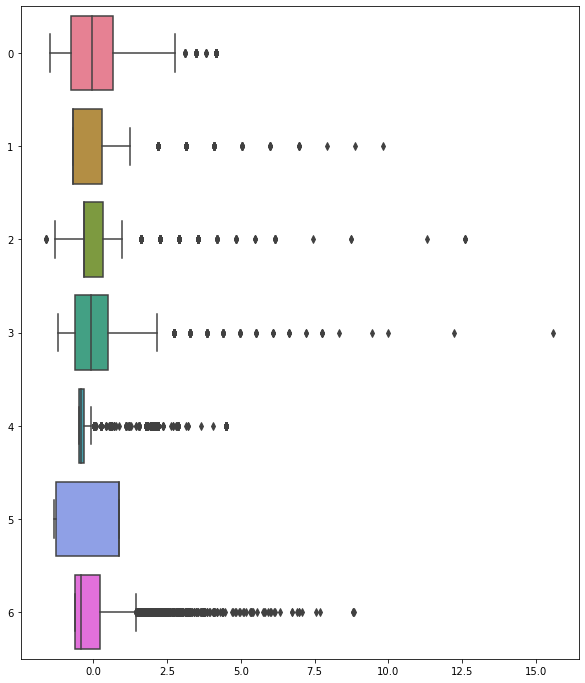

In [37]:
import matplotlib.pyplot as plt
import seaborn as sns

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

plt.figure(figsize=(10,12))
ax = sns.boxplot(data=X_train_scaled, orient="h", palette="husl")

If we don't get good results we might want to come back and deal with the outliers

## 8. Training KNN with 7 Features

In [38]:
knn = KNeighborsRegressor()
kpar = {'n_neighbors': np.arange(1, 21, 2),
       'weights': ['uniform', 'distance'],
       'algorithm': ['ball_tree', 'kd_tree', 'brute'],
       'p': [1,2]
      }
kgrid = GridSearchCV(knn, kpar, n_jobs=-1, cv=10)
kgrid.fit(X_train_scaled, y_train)     

print('Best Parameters:', kgrid.best_params_)
print('Best Score:', kgrid.best_score_)

Best Parameters: {'algorithm': 'brute', 'n_neighbors': 19, 'p': 1, 'weights': 'uniform'}
Best Score: 0.0691019160516593


In [39]:
knn = KNeighborsRegressor(algorithm='brute', n_neighbors=19, 
                        p=1, weights='uniform')
knn_mse = cross_val_score(knn, X_train_scaled, y_train, cv=10, n_jobs=-1, 
                             scoring="neg_mean_squared_error") 
knn_rmse = np.sqrt(np.absolute(knn_mse))
print('RMSE:', knn_rmse)
print('Avg_RMSE:', knn_rmse.mean())
print('Std_RMSE:', knn_rmse.std())

RMSE: [430.04376745 210.55232161 144.80655904 141.79051923 422.85837113
 457.49145461 568.49728382 158.30198639 451.15999849 126.14806679]
Avg_RMSE: 311.1650328557934
Std_RMSE: 160.59938633030455


In [44]:
model_df['KNN_7'] = [430.04376745, 210.55232161, 144.80655904, 141.79051923,
                     422.85837113, 457.49145461, 568.49728382, 158.30198639,
                     451.15999849, 126.14806679, 311.1650328557934, 160.59938633030455]
model_df

,RMSE,OLS_LR_all,OLS_LR_36,ElasNet_36,KNN_all,RandFor_all,KNN_pca0.95,RanFor_pca0.95,OLS_RFECV81,KNN_7
0,rmse_1,425.931,552.859,552.819,417.219,422.306,438.555,439.472,425.890,430.044
1,rmse_2,183.527,210.802,210.359,185.514,184.979,188.600,211.007,182.900,210.552
2,rmse_3,134.728,123.628,118.106,123.416,134.961,127.743,141.790,130.363,144.807
3,rmse_4,138.456,128.244,123.103,135.151,136.021,146.013,146.559,137.695,141.791
4,rmse_5,413.153,590.703,590.501,419.743,421.211,420.365,427.427,411.767,422.858
5,rmse_6,447.291,463.421,461.630,450.736,449.103,446.460,423.956,446.818,457.491
6,rmse_7,568.169,143.516,138.461,566.424,572.348,568.933,572.693,565.041,568.497
7,rmse_8,140.921,123.251,119.284,134.056,150.106,143.565,153.617,139.445,158.302
8,rmse_9,444.477,129.995,123.141,442.413,447.136,444.518,445.078,444.541,451.160
9,rmse_10,130.011,412.477,412.350,113.691,114.374,124.292,151.157,113.287,126.148


## 9. Training Random Forest with 7 Features

In [45]:
ran = RandomForestRegressor(max_depth=2, min_samples_leaf=1,
                            min_samples_split=2)
ranfo_mse = cross_val_score(ran, X_train_scaled, y_train, cv=10, n_jobs=-1, 
                             scoring="neg_mean_squared_error") 
ranfo_rmse = np.sqrt(np.absolute(ranfo_mse))
print('RMSE:', ranfo_rmse)
print('Avg_RMSE:', ranfo_rmse.mean())
print('Std_RMSE:', ranfo_rmse.std())

RMSE: [435.53001694 197.81929847 177.40858838 134.14344988 423.65414056
 449.83918495 575.33050955 155.35068637 444.71184706 117.52541647]
Avg_RMSE: 311.13131386329576
Std_RMSE: 160.87827782391386


In [46]:
model_df['RandFor_7'] = [435.53001694, 197.81929847, 177.40858838, 134.14344988,
                         423.65414056, 449.83918495, 575.33050955, 155.35068637,
                         444.71184706, 117.52541647, 311.13131386329576, 160.87827782391386]